# Configuration

## Dependencies

In [161]:
# import necessary packages
import os
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import seaborn as sns
import neuropythy as ny
import matplotlib as mpl
import itertools
import warnings
import pingouin as pg
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
from itertools import product
from visualization import plot_annot_properties as vis
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Paths

In [162]:
cache_path       = Path('/data/crcns2021/hcpannot-cache')
image_cache_path = cache_path / 'annot-images'
v123_cache_path  = cache_path / 'annot-v123'
csulc_cache_path = cache_path / 'annot-csulc'
# The save path of the data branch:
data_path = Path('/data/crcns2021/results/data_branch/save')
# The processing path and subpaths:
proc_path    = Path('/data/crcns2021/results/proc')
traces_path  = proc_path / 'traces'
paths_path   = proc_path / 'paths'
means_path   = proc_path / 'means'
labels_path  = proc_path / 'labels'
reports_path = proc_path / 'reports'
fig_dir      = proc_path / 'figures'

# The file of visual surface areas for the ventral data.
ventral_sarea_path = proc_path / 'ventral_sareas.tsv'

# The hcpannot library path; if hcpannot is not on the path for
# this notebook, the notebook will try to figure out where it is
# and will use this directory as a backup.
hcpannot_lib_path = Path('~/code/hcp-annot-vc_analysis')

# If you aren't using /data
os.environ['HCPANNOT_LOAD_PATH'] = os.fspath(cache_path)

## Font settings

In [197]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

## hcpannot settings and functions

In [164]:
# Make sure we can find the hcpannot library. If we were given a path for the
# hcpannot library, we add it to the system path here.
if hcpannot_lib_path:
    hlp = os.path.expandvars(os.fspath(hcpannot_lib_path))
    hlp = os.path.expanduser(hlp)
    if hlp.strip('/').endswith('hcpannot'):
        warnings.warn(
            "adding hcpannot_lib_path that ends with 'hcpannot';"
            " the hcpannot_lib_path should contain the hcpannot directory")
    if os.path.isdir(hlp):
        sys.path.append(hlp)
    else:
        raise ValueError("hcpannot_lib_path is not a directory")
# We try importing it and if we fail, we check to see if we are just running
# the notebook from the work directory and try again.
try:
    import hcpannot
except ModuleNotFoundError:
    hcpannot = None
    if os.getcwd().endswith('/work'):
        hlp = os.path.abspath('..')
        sys.path.append(hlp)
        
# Now we can import the hcp-annot-vc library. (It may have been imported
# above in the try block, but that's fine!)
import hcpannot

# Note the cache path we want to use outside the docker container;
# normally this gets set by the Docker startup, so here outside
# the docker container we set it manually.
hcpannot.interface.default_load_path = str(cache_path)
# We have to update some data after setting this.

# Subject lists. These are defined in the analysis subpackage of
# the hcpannot library, and subject_list_<x> is the <x>th list of
# subject IDs that we assigned.
from hcpannot.config import (
    subject_list,
    subject_list_1,
    subject_list_2,
    subject_list_3)
# The subject IDs we are processing over, as a numpy array.
sids = np.array(subject_list)

# The mean rater's name ('mean') and some plotting functions are also defined in
# the hcpannot.analysis subpackage.
from hcpannot.analysis import plot_contours

# Finally, the proc and meanproc functions, which give us the processed data.
from hcpannot.proc import proc

In [165]:
def load_report(region, rater, sid, h):
    """Loads surface area report for the region, rater, sid, and hemisphere.
    
    The region should be the name of one of the contour regions, e.g.
    `'ventral'`. Loads a dictionary of the processing report for the given
    rater, subject, and hemisphere, and returns a processed version of that
    report. The processing includes both square-mm and percentage reports of the
    surface area.
    
    If the file for the report is not found, it is skipped and the values are
    left as NaN.
    """
    from json import load
    data = {
        'rater':rater,
        'sid':sid,
        'hemisphere':h}
    for k in region_areas[region]:
        data[f'{k}_mm2'] = np.nan
        data[f'{k}_percent'] = np.nan
    try:
        path = os.path.join(reports_path, rater, str(sid))
        flnm = os.path.join(path, f'{h}.{region}_sareas.json')
        with open(flnm, 'rt') as fl:
            sarea = load(fl)
        for (k,v) in sarea.items():
            data[f'{k}_mm2'] = v
            if k != 'cortex':
                data[f'{k}_percent'] = v * 100 / sarea['cortex']
    except Exception as e:
        pass
    return data
def load_allreports(region, include_mean=True, sids=subject_list):
    """Loads all reports for a region and returns a dataframe of them.
    
    This runs `load_report` over all raters, subjects, and hemispheres and
    returns a dataframe of all the reports. If a report file is not found,
    then the row is left with NaNs indicating missing data.
    """
    if include_mean:
        if include_mean == True:
            include_mean = 'mean'
        include_mean = [include_mean]
    else:
        include_mean = []
    raters = (region_raters[region] + include_mean)
    return pd.DataFrame(
        [load_report(region, rater, sid, h)
         for rater in raters
         for sid in sids
         for h in ('lh', 'rh')])
def nestget(d, k):
    """Retrieves nested data from the proc dictionaries.
    
    Certain keys such as `'boundaries'` are accessible in the dictionaries that
    are returned by the `proc` function only via the `'nested_data'` key, which
    typically contains another proc dictionary with additional data. The
    `nestget` function gets data from these embedded dictionaries.
    """
    while k not in d:
        d = d['nested_data']
    return d[k]

## Annotation meta-data

In [166]:
# The sets of raters we use.
ventral_raters = [
    'BrendaQiu',
    'bogengsong',
    'JiyeongHa',
    'lindazelinzhao',
    'nourahboujaber',
    'jennifertepan']
region_raters = {
    'ventral': ventral_raters}

# The visual areas included in each pipeline/region.
region_areas = {
    'early': ('V1', 'V2', 'V3'),
    'ventral': ('hV4', 'VO1', 'VO2', 'VO'),
    'dorsal': ('V3a', 'V3b', 'IPS0', 'LO1')}

roi_list = []
roi_list += [k for k in region_areas['early']]
roi_list += [k for k in region_areas['ventral']]
roi_list += ['cortex']

# The hemispheres we are processing over.
hemis = ['lh', 'rh']

# Load early and ventral data

In [167]:
wide_early_df = ny.data['hcp_lines'].surface_area_dataframe
cols = ['sid','anatomist','roiLV1','roiLV2','roiLV3','roiRV1','roiRV2','roiRV3']
new_cols = ['sid','researcher','lh_V1_mm2','lh_V2_mm2','lh_V3_mm2','rh_V1_mm2','rh_V2_mm2','rh_V3_mm2']
wide_early_df = wide_early_df[cols]
wide_early_df = wide_early_df.rename(columns=dict(zip(cols, new_cols)))

In [168]:
early_df = pd.DataFrame({})
for hemi in ['lh', 'rh']:
    tmp_cols = [col for col in wide_early_df.columns if hemi in col]
    tmp_new_cols = [col.replace(f'{hemi}_', '') for col in tmp_cols]
    tmp = wide_early_df[['sid', 'researcher'] + tmp_cols]
    tmp = tmp.rename(columns=dict(zip(tmp_cols, tmp_new_cols)))
    tmp['hemisphere'] = hemi
    early_df = pd.concat((early_df, tmp))
early_df

,sid,researcher,V1_mm2,V2_mm2,V3_mm2,hemisphere
0,100610,A1,2265.887920,1780.173294,1143.821972,lh
1,100610,A2,2240.237938,1661.168048,1227.444715,lh
2,100610,A3,2174.752668,1566.739454,1085.699232,lh
3,100610,A4,2105.550586,1889.817786,1066.602000,lh
4,100610,mean,2182.648869,1728.088569,1119.816370,lh
...,...,...,...,...,...,...
900,901442,A1,1112.422321,981.976593,1008.520810,rh
901,901442,A2,1092.132772,986.305241,1052.124268,rh
902,901442,A3,1090.585286,966.060233,917.979071,rh
903,901442,A4,1034.806269,1058.982934,1000.117598,rh


In [169]:
ventral_df = load_allreports('ventral', sids=sids)
ventral_df = ventral_df.rename(columns = {'rater': 'researcher'})
ventral_df['VO_mm2'] = ventral_df[['VO1_mm2', 'VO2_mm2']].sum(axis = 1, skipna = True)
ventral_df['VO_percent'] = ventral_df[['VO1_percent', 'VO2_percent']].sum(axis = 1, skipna = True)

# Merge early and ventral dfs

In [170]:
visual_df = pd.merge(early_df, ventral_df, on=['sid','researcher', 'hemisphere'])
for roi in ['V1', 'V2', 'V3']:
    visual_df[f'{roi}_percent'] = (visual_df[f'{roi}_mm2'] / visual_df[f'cortex_mm2'])*100
visual_df

,sid,researcher,V1_mm2,V2_mm2,V3_mm2,hemisphere,hV4_mm2,hV4_percent,VO1_mm2,VO1_percent,VO2_mm2,VO2_percent,VO_mm2,VO_percent,cortex_mm2,V1_percent,V2_percent,V3_percent
0,100610,mean,2182.648869,1728.088569,1119.816370,lh,793.065979,0.766467,249.325195,0.240963,246.177490,0.237921,495.502686,0.478884,103470.296875,2.109445,1.670130,1.082259
1,118225,mean,1979.312683,1669.270603,1064.189967,lh,642.431396,0.597612,322.542725,0.300040,258.943207,0.240878,581.485931,0.540918,107499.742188,1.841226,1.552814,0.989947
2,140117,mean,1153.694862,1118.138452,872.083832,lh,670.877441,0.771275,267.779480,0.307853,175.042328,0.201238,442.821808,0.509091,86982.890625,1.326347,1.285469,1.002592
3,158136,mean,1231.193647,1271.163609,1001.229745,lh,583.013306,0.657586,186.084076,0.209886,113.975067,0.128553,300.059143,0.338439,88659.679688,1.388674,1.433756,1.129295
4,172130,mean,1022.975665,1164.040613,886.230702,lh,477.573547,0.524038,291.366699,0.319714,279.375854,0.306557,570.742554,0.626271,91133.414062,1.122503,1.277293,0.972454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,406836,mean,1273.361188,1290.200584,1045.837380,rh,455.950562,0.522071,178.490631,0.204375,145.727722,0.166861,324.218353,0.371235,87334.960938,1.458020,1.477301,1.197501
358,572045,mean,974.767644,870.247724,904.958032,rh,634.182922,0.781434,232.056168,0.285937,165.746674,0.204231,397.802841,0.490168,81156.351562,1.201098,1.072310,1.115080
359,706040,mean,808.052458,773.187416,691.081453,rh,633.468933,0.801309,319.460571,0.404103,146.703613,0.185573,466.164185,0.589676,79054.226562,1.022150,0.978047,0.874187
360,818859,mean,1381.183600,1237.964415,944.633979,rh,517.833923,0.485281,322.679718,0.302395,220.538010,0.206674,543.217728,0.509069,106708.062500,1.294357,1.160141,0.885251


# Wide format (hemi + ROIs as columns)

In [171]:
wide_ventral_df = {}
for hemi in ['lh','rh']:
    tmp = ventral_df.query('hemisphere == @hemi')
    tmp_cols = [f'{col}_mm2' for col in region_areas['ventral']]
    tmp_cols += [f'{col}_percent' for col in region_areas['ventral']]
    tmp_cols += ['cortex_mm2']
    tmp_new_cols = [f'{hemi}_{col}' for col in tmp_cols if col ]
    tmp_new_cols += ['sid', 'researcher']
    
    tmp = tmp.rename(columns=dict(zip(tmp_cols, tmp_new_cols)))
    wide_ventral_df[hemi] = tmp.drop(columns=['hemisphere'])

wide_ventral_df = pd.merge(wide_ventral_df['lh'], 
                           wide_ventral_df['rh'], 
                           on=['researcher','sid'])

In [172]:
wide_visual_df = pd.merge(wide_early_df, wide_ventral_df, on=['sid','researcher'])
for hemi, roi in product(['lh','rh'], ['V1', 'V2', 'V3']):
    wide_visual_df[f'{hemi}_{roi}_percent'] = (wide_visual_df[f'{hemi}_{roi}_mm2'] / wide_visual_df[f'{hemi}_cortex_mm2'])*100
wide_visual_df

,sid,researcher,lh_V1_mm2,lh_V2_mm2,lh_V3_mm2,rh_V1_mm2,rh_V2_mm2,rh_V3_mm2,lh_hV4_mm2,lh_hV4_percent,...,rh_VO2_percent,rh_VO_mm2,rh_VO_percent,rh_cortex_mm2,lh_V1_percent,lh_V2_percent,lh_V3_percent,rh_V1_percent,rh_V2_percent,rh_V3_percent
0,100610,mean,2182.648869,1728.088569,1119.816370,1860.693153,1659.008599,1172.995850,793.065979,0.766467,...,0.313579,529.419952,0.509633,103882.664062,2.109445,1.670130,1.082259,1.791149,1.597002,1.129155
1,118225,mean,1979.312683,1669.270603,1064.189967,2051.494042,1849.540834,1352.400127,642.431396,0.597612,...,0.183340,494.691101,0.450700,109760.562500,1.841226,1.552814,0.989947,1.869063,1.685069,1.232137
2,140117,mean,1153.694862,1118.138452,872.083832,1116.527387,1207.856324,865.760388,670.877441,0.771275,...,0.143485,448.598587,0.515941,86947.718750,1.326347,1.285469,1.002592,1.284136,1.389175,0.995725
3,158136,mean,1231.193647,1271.163609,1001.229745,1205.712993,1355.516790,1008.570664,583.013306,0.657586,...,0.142359,383.290543,0.426663,89834.515625,1.388674,1.433756,1.129295,1.342149,1.508904,1.122698
4,172130,mean,1022.975665,1164.040613,886.230702,1022.367207,1111.529883,782.037635,477.573547,0.524038,...,0.303203,501.950180,0.543340,92382.265625,1.122503,1.277293,0.972454,1.106670,1.203185,0.846524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,406836,mean,1444.961363,1335.570071,1114.681135,1273.361188,1290.200584,1045.837380,417.560699,0.485021,...,0.166861,324.218353,0.371235,87334.960938,1.678406,1.551342,1.294767,1.458020,1.477301,1.197501
177,572045,mean,1136.901352,1026.256552,875.898848,974.767644,870.247724,904.958032,657.147827,0.807228,...,0.204231,397.802841,0.490168,81156.351562,1.396548,1.260634,1.075938,1.201098,1.072310,1.115080
178,706040,mean,NaN,NaN,NaN,808.052458,773.187416,691.081453,355.874054,0.451888,...,0.185573,466.164185,0.589676,79054.226562,NaN,NaN,NaN,1.022150,0.978047,0.874187
179,818859,mean,1338.753442,1248.840014,1060.750740,1381.183600,1237.964415,944.633979,535.161011,0.518794,...,0.206674,543.217728,0.509069,106708.062500,1.297811,1.210647,1.028310,1.294357,1.160141,0.885251


# Fig 1. Surface area correlations between different ROIs

In [173]:
plot_cols = [k for k in visual_df.columns if '_mm2' in k]
new_plot_cols = [k[:-4].replace('_', ' ') for k in plot_cols]

plot_df = visual_df.query('researcher == "mean"')
plot_df = plot_df[['sid'] + plot_cols]
plot_df = plot_df.groupby(['sid']).mean().reset_index() # average across hemispheres
plot_df = plot_df[plot_cols]

plot_df = plot_df.rename(columns=dict(zip(plot_cols, new_plot_cols)))

<Axes: >

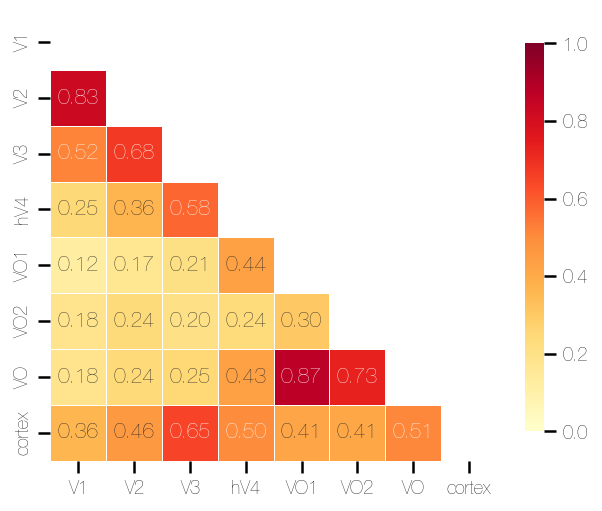

In [174]:
corr_matrix, mask = vis.get_correlation_matrix(plot_df)

vis.heatmap_surface_area(corr_matrix, 
                         mask=mask, 
                         height=5, 
                         annot=True, 
                         boundary_line=None, 
                         save_path=os.path.join(fig_dir, 'avg_hemis_surface_area_correlations.svg'))

In [175]:
plot_cols = []
for hemi, roi in itertools.product(hemis, roi_list):
    plot_cols.append(f'{hemi}_{roi}_mm2')

plot_df = wide_visual_df.query('researcher == "mean"')
plot_df = plot_df[plot_cols]

new_plot_cols = [k[:-4].replace('_', ' ') for k in plot_cols]
new_plot_cols = [k.replace('lh', 'LH').replace('rh', 'RH') for k in new_plot_cols]
plot_df = plot_df.rename(columns=dict(zip(plot_cols, new_plot_cols)))

<Axes: >

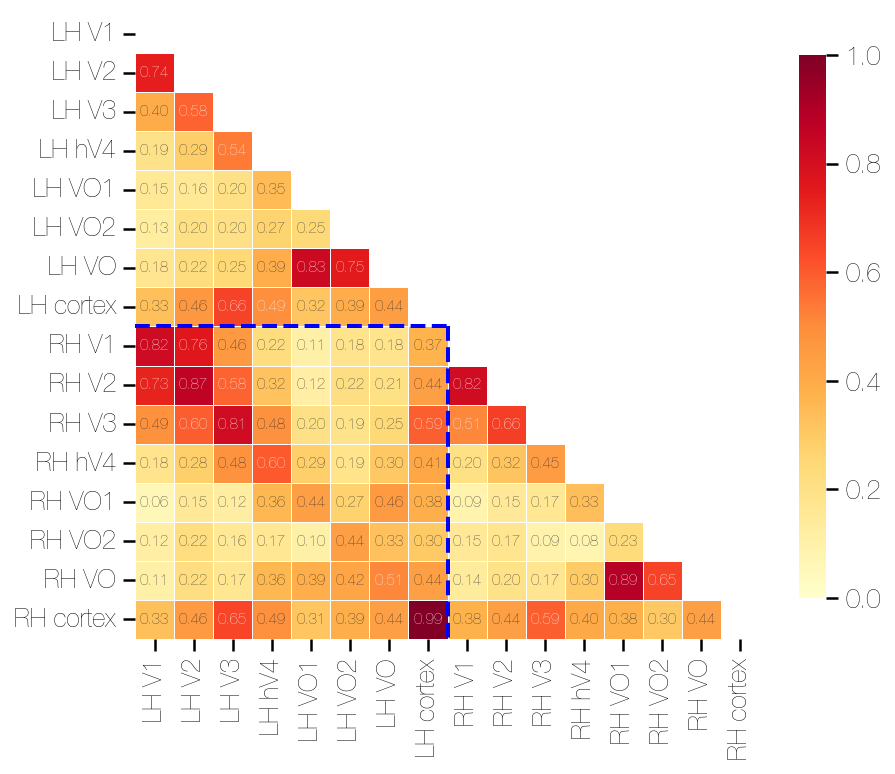

In [176]:
corr_matrix, mask = vis.get_correlation_matrix(plot_df)

vis.heatmap_surface_area(corr_matrix, 
                         mask=mask, 
                         height=7, 
                         annot=True, 
                         boundary_line=len(roi_list), 
                         save_path=os.path.join(fig_dir, 'lh_rh_surface_area_correlations.svg'))

# Fig 2. Mean surface area comparison between different ROIs 

In [177]:
tmp_cols = [k for k in visual_df.columns if f'_percent' in k]
new_cols = [k.replace('_percent','') for k in tmp_cols]
plot_df = visual_df[['sid','researcher','hemisphere']+tmp_cols]
plot_df = plot_df.rename(columns=dict(zip(tmp_cols, new_cols)))
plot_df = plot_df.melt(id_vars=['sid','researcher','hemisphere'], var_name='ROI', value_name='percent')
plot_df = plot_df.replace({'hemisphere': {'lh': 'LH', 'rh': 'RH'}})

<Figure size 1008x1008 with 0 Axes>

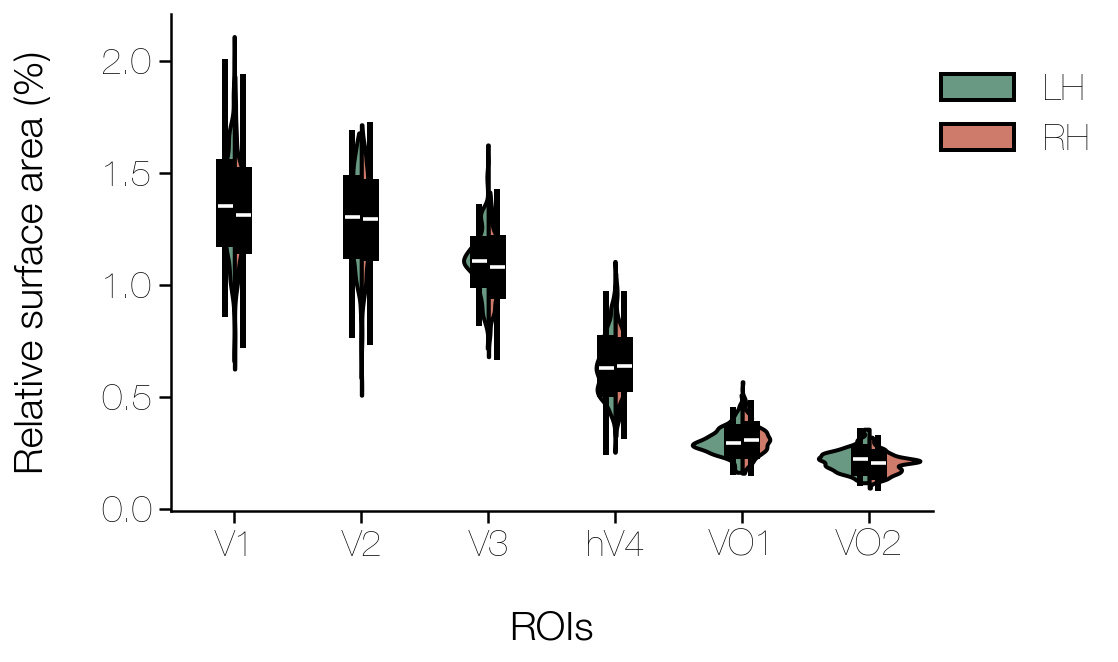

In [178]:
my_cmap = sns.diverging_palette(150, 20, s=50, l=60, sep=1, n=2, as_cmap=False)
grid = vis.violinplot_surface_area(plot_df, 
                                   hue='hemisphere', hue_order=['LH','RH'],
                                   x='ROI', x_order=['V1', 'V2', 'V3', 'hV4', 'VO1', 'VO2'], 
                                   y='percent', 
                                   bw=.2, height=5,
                                   cmap=my_cmap, 
                                   save_path=os.path.join(fig_dir, 'relative_surface_area_distributions.svg'));

# Fig 3. Ventral only: Surface area distributions for each researcher

In [179]:
area_type='percent'
tmp_cols = [k for k in ventral_df.columns if f'_{area_type}' in k]
new_cols = [k.replace(f'_{area_type}','') for k in tmp_cols]
plot_ventral_df = ventral_df.query('researcher != "mean"')
plot_ventral_df = plot_ventral_df[['sid','researcher','hemisphere']+tmp_cols]
plot_ventral_df = plot_ventral_df.rename(columns=dict(zip(tmp_cols, new_cols)))
plot_ventral_df = pd.melt(plot_ventral_df, 
                          id_vars=['researcher','sid','hemisphere'], 
                          var_name='ROI', value_name=area_type)
plot_ventral_df = plot_ventral_df.replace({'hemisphere': {'lh': 'LH', 'rh': 'RH'}})


<Figure size 1008x1008 with 0 Axes>

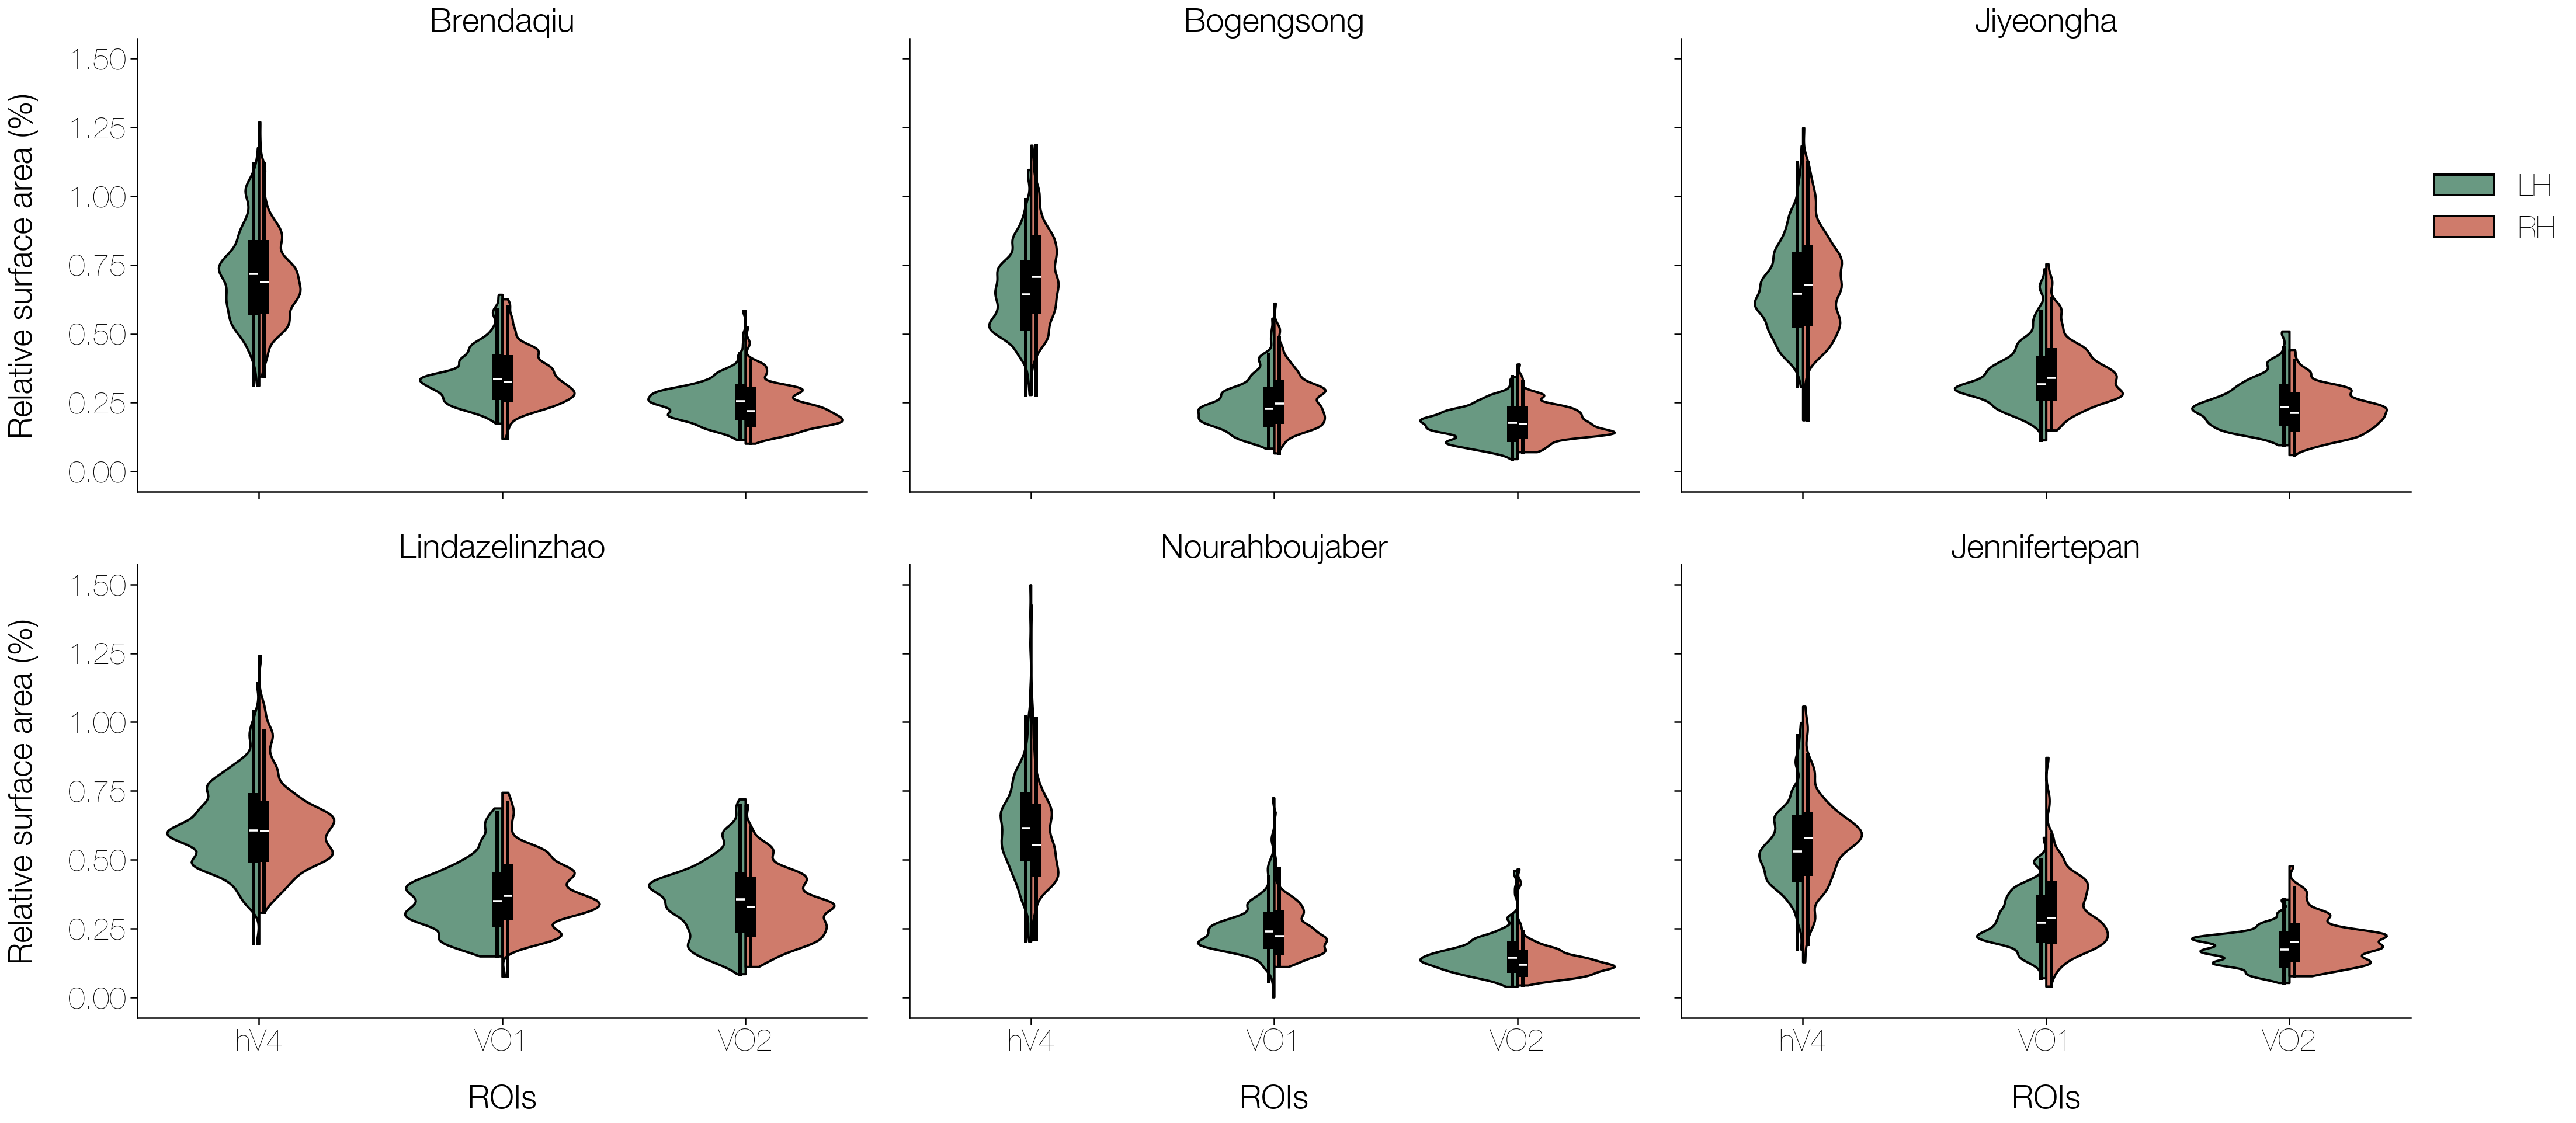

In [180]:
grid = vis.violinplot_surface_area(plot_ventral_df, 
                                   x='ROI', x_order=['hV4', 'VO1', 'VO2'], 
                                   y='percent',
                                   hue='hemisphere', hue_order=['LH','RH'],
                                   col='researcher',
                                   col_wrap=3,
                                   height=7,
                                   bw=.2,
                                   cmap=my_cmap,
                                   save_path=os.path.join(fig_dir, 'ventral_researcher_relative_surface_area_distributions.svg'));

# Twin data analysis

In [181]:
ds = ny.data['hcp_lines']
twin_df = pd.DataFrame({'twin_type':[], 'sid1':[], 'sid2':[]})
twin_types = [k for k in ds.retinotopy_sibling_pairs.keys() if not k=='nontwin_siblings']
for k in twin_types:
    twin_ids = ds.retinotopy_sibling_pairs[k]
    tmp = pd.DataFrame({'twin_type':[], 'sid1':[], 'sid2':[]})
    if twin_ids.ndim != 2:
        twin_ids = twins_ids.reshape(1,-1) 
    tmp['sid1'] = twin_ids[:,0]
    tmp['sid2'] = twin_ids[:,1]
    tmp['twin_type'] = k
    twin_df = pd.concat((twin_df, tmp), ignore_index=True)
    
twin_df = twin_df.reset_index().rename(columns={'index':'twin_index'})
twin_df['twin_index'] = twin_df['twin_index'].astype(int)
long_twin_df = pd.melt(twin_df, id_vars=['twin_type', 'twin_index'], 
                       value_vars=['sid1','sid2'], 
                       var_name='sid_type', value_name='sid')
long_twin_df['sid'] = long_twin_df['sid'].astype(int)

# Twin surface area dataframe for calculating icc

For one case (one twin type, all twins, one hemisphere, one roi), it takes about 50.4 ms. 

In [182]:
%%time
pg.intraclass_corr(data=tmp, 
                   targets='twin_index', 
                   raters='sid_type', 
                   ratings=f'{hemi}_{roi}_percent', 
                   nan_policy='omit').query('Type == "ICC1"')

AssertionError: 

## icc for all cases

In [183]:
def calculate_icc(long_twin_df, surface_area_df, twin_type, hemi, roi):
    if hemi in ['lh', 'rh']:
        ratings = f'{hemi}_{roi}_percent'
    else:
        ratings = f'{roi}_percent'
        surface_area_df[ratings] = surface_area_df[f'lh_{ratings}'] + surface_area_df[f'rh_{ratings}']
    tmp_cols = ['sid', ratings]
    tmp = long_twin_df.query('twin_type == @twin_type')
    tmp = tmp.merge(surface_area_df[tmp_cols], on='sid')
    result = pg.intraclass_corr(data=tmp, 
                                targets='twin_index', 
                                raters='sid_type', 
                                ratings=ratings, 
                                nan_policy='omit').query('Type == "ICC1"')
    result = result.drop(columns={'Type','Description'})
    result['hemi'] = [hemi]
    result['ROI'] = [roi]
    result['twin_type'] = [twin_type]
    return result

def calculate_icc_for_all(long_twin_df, surface_area_df, twin_types, hemis, rois, save_path=None):
    if save_path is not None and os.path.exists(save_path):
        return pd.read_hdf(save_path)
    else:
        twin_icc_df = pd.DataFrame({})
        for twin_type, hemi, roi in tqdm(product(twin_types, hemis, rois)):
            result = calculate_icc(long_twin_df, surface_area_df, twin_type, hemi, roi)
            twin_icc_df = pd.concat((twin_icc_df, result), ignore_index=True)
    # Ignore PyTables PerformanceWarning
        if save_path is not None:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=pd.io.pytables.PerformanceWarning)
                twin_icc_df.to_hdf(save_path, key='df')
            print(f'{save_path} saved')
        return twin_icc_df

In [184]:
twin_types = [k for k in ds.retinotopy_sibling_pairs.keys() if not k=='nontwin_siblings']
 
twin_icc_df = pd.DataFrame({})
for hemi, ttype in product(['sum'], twin_types):
    save_path = os.path.join(proc_path, 'twins', f'icc_hemi-{hemi}_ttype-{ttype}_roi-all.h5')
    result = calculate_icc_for_all(long_twin_df, wide_visual_df, [ttype], [hemi], roi_list[:-1], save_path)
    twin_icc_df = pd.concat((twin_icc_df, result), ignore_index=True)
    

In [185]:
mono_df = twin_icc_df.query('twin_type == "monozygotic_twins"')[['hemi','ROI','ICC']]
dizy_df = twin_icc_df.query('twin_type == "dizygotic_twins"')[['hemi','ROI','ICC']]
h2_df = pd.merge(mono_df, dizy_df, on=['hemi','ROI'])
h2_df['h2'] = 2*(h2_df['ICC_x'] - h2_df['ICC_y'])
h2_df = h2_df.rename(columns={'ICC_x':'mono_ICC', 'ICC_y':'dizy_ICC'})

# For bootstraps

In [186]:
def sample_with_condition(df, n_samples=100, min_count=10):
    """sample at least 5 pairs for each twin type while allowing resampling"""
    while True:
        sampled_numbers = random.choices(df.twin_index.unique(), k=n_samples)
        sampled_df = pd.DataFrame({})
        for new_i, i in enumerate(sampled_numbers):
            tmp = df.query('twin_index == @i')[['sid_type','twin_type','sid']]
            tmp['twin_index'] = new_i
            sampled_df = pd.concat((sampled_df, tmp), ignore_index=True)
        counts = sampled_df['twin_type'].value_counts()
        if all(counts >= min_count):
            break
    return sampled_df

def filter_nan_and_unrelated_pairs(twin_df, sampled_surface_area_df):
    """Filter out unrelated pairs & pairs that has nan values"""
    nan_list = sampled_surface_area_df[sampled_surface_area_df.isna().any(axis=1)]['sid'].tolist()
    filtered_df = twin_df.query('twin_type != "unrelated_pairs" & sid not in @nan_list')
    counts = filtered_df.twin_index.value_counts()
    # Step 2: Filter counts to get only those with more than one occurrence
    filtered_counts = counts[counts > 1]
    # Step 3: Filter the original DataFrame to keep only those rows
    # whose twin_index is in the filtered_counts index
    filtered_df = filtered_df[filtered_df['twin_index'].isin(filtered_counts.index)]
    return filtered_df

def bootstrap_calculate_icc_for_all(long_twin_df, surface_area_df, n_samples, n_bootstraps, hemi, roi, save_path=None):
    if save_path is not None and os.path.exists(save_path):
        return pd.read_hdf(save_path)
    else:
        np.random.seed(0) # For reproducible results
        sampled_surface_area_df = surface_area_df[['sid', f'lh_{roi}_percent',f'rh_{roi}_percent']]
        filtered_df = filter_nan_and_unrelated_pairs(long_twin_df, sampled_surface_area_df)
        twin_icc_df = pd.DataFrame({})
        for i in tqdm(range(n_bootstraps)):
            bts_tmp_df = sample_with_condition(filtered_df, n_samples, min_count=10)
            mono_result = calculate_icc(bts_tmp_df, surface_area_df, 'monozygotic_twins', hemi, roi)
            mono_result = mono_result.rename(columns={'ICC': 'mono_ICC'})
            dizy_result = calculate_icc(bts_tmp_df, surface_area_df, 'dizygotic_twins', hemi, roi)
            dizy_result = dizy_result.rename(columns={'ICC': 'dizy_ICC'})
            bts_df = pd.concat((mono_result, dizy_result['dizy_ICC']), axis=1)
            bts_df['bootstrap'] = i
            bts_df = bts_df[['bootstrap','ROI','hemi','mono_ICC','dizy_ICC']]
            twin_icc_df = pd.concat((twin_icc_df, bts_df), axis=0, ignore_index=True)  
        twin_icc_df['h2'] = 2*(twin_icc_df['mono_ICC'] - twin_icc_df['dizy_ICC']) #Falconer's formula
        # Ignore PyTables PerformanceWarning
        if save_path is not None:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=pd.io.pytables.PerformanceWarning)
                twin_icc_df.to_hdf(save_path, key='df')
        return twin_icc_df


In [187]:
n_bootstraps=1000
bts_icc_df = pd.DataFrame({})
for roi in roi_list[::-1][1:]:
    save_path = os.path.join(proc_path, 'twins', f'bootstraps-{n_bootstraps}_icc_hemi-{hemi}_ttype-all_roi-{roi}.h5')
    tmp = bootstrap_calculate_icc_for_all(long_twin_df, wide_visual_df, 84, n_bootstraps, 'sum', roi, save_path=save_path)
    bts_icc_df = pd.concat((bts_icc_df, tmp), ignore_index=True)

/home/jiyeongha/.conda/envs/vwm/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


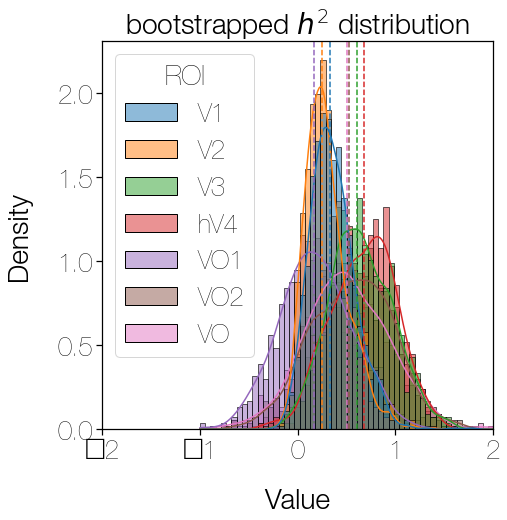

In [196]:
palette = sns.color_palette("tab10", len(roi_list[:-1]))  # 10 colors from the tab10 palette
sns.histplot(data=bts_icc_df, x='h2', hue='ROI', hue_order=roi_list[:-1],
             kde=True, stat='density', alpha=.5, 
             common_norm=False, palette=palette)
plt.title(r'bootstrapped $h^{2}$ distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.xlim([-2, 2])

# Iterate over the rows of df2 to add vertical lines and text
for i,roi in enumerate(roi_list[:-1]):
    plt.axvline(x=h2_df.query('ROI == @roi')['h2'].item(), color=palette[i], linestyle='--')  # Add a vertical line; adjust color/style as needed

fig_path=os.path.join(fig_dir, 'bootstrapped_h2_distribution.svg')
#plt.savefig(fig_path)
plt.show()

# Fig 4b. Heriability ICC plot
## seperately for each hemisphere, and use CI values as error bars

In [189]:
bts_icc_std_df = bts_icc_df.groupby(['ROI','hemi']).std().reset_index()
bts_icc_std_df = bts_icc_std_df.rename(columns={'h2':'std_h2', 'mono_ICC':'std_mono_ICC', 'dizy_ICC':'std_dizy_ICC'})
final_icc_df = pd.merge(h2_df, bts_icc_std_df, on=['ROI','hemi'])

In [190]:
categories = twin_icc_df['ROI'].unique()
hues = twin_icc_df['twin_type'].unique()
category_positions = np.arange(len(categories))  # Base positions for categories
color_map = dict(zip(['mono_ICC','dizy_ICC','unrelated_pairs'],  ['blue','orange','grey'])) # Create a dictionary to map hues to colors
labels = dict(zip(['mono_ICC','dizy_ICC','unrelated_pairs'], ['Monozygotic','Dizygotic','Unrelated']))

In [191]:
twin_df

,twin_index,twin_type,sid1,sid2
0,0,unrelated_pairs,100610.0,102311.0
1,1,unrelated_pairs,100610.0,102816.0
2,2,unrelated_pairs,100610.0,104416.0
3,3,unrelated_pairs,100610.0,108323.0
4,4,unrelated_pairs,100610.0,109123.0
...,...,...,...,...
14359,14359,monozygotic_twins,397760.0,467351.0
14360,14360,monozygotic_twins,412528.0,951457.0
14361,14361,monozygotic_twins,547046.0,901139.0
14362,14362,monozygotic_twins,552241.0,973770.0


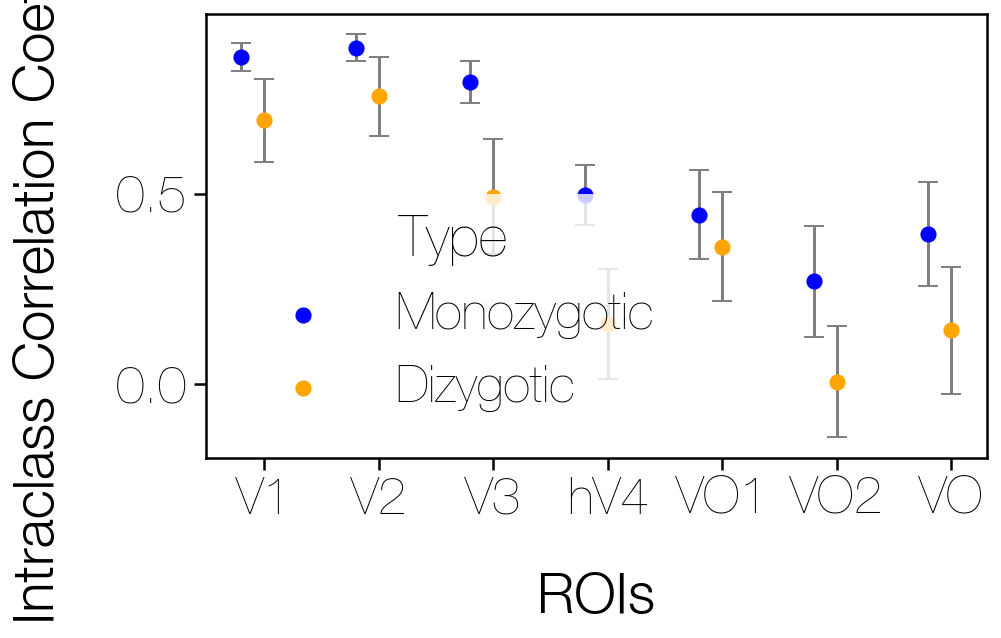

In [192]:
# fix the errorbar from std to 68% ci 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
hue_offsets = np.linspace(-0.2, 0.2, len(hues))  # Adjust based on the number of hues and desired spacing

for i, category in enumerate(categories):
    for j, hue in enumerate(['mono_ICC','dizy_ICC']):
        # Filter data for this category and hue
        subset = final_icc_df[final_icc_df['ROI'] == category]
        x_positions = category_positions[i] + hue_offsets[j]
        # Add error bars (assuming 'CI95%' column contains [lower, upper] bounds)
        for _, row in subset.iterrows():
            ax.errorbar(x_positions, 
                        row[hue], c='gray', linewidth=1.5,
                        yerr=row[f'std_{hue}'], 
                        fmt='none', capsize=5, zorder=1)
        # Plot points
        ax.scatter([x_positions] * len(subset), 
                   subset[hue], s=50,  
                   color = color_map[hue],
                   label=labels[hue] if i == 0 else "", zorder=2)

    ax.set_xticks(category_positions)
    ax.set_xticklabels(categories)
    ax.set_xlabel('ROIs')
    ax.set_ylabel('Intraclass Correlation Coefficient')
    lgd = ax.legend(title='Type')
    lgd.get_frame().set_edgecolor('none')  # Remove the border of the legend

plt.subplots_adjust()
plt.savefig(os.path.join(fig_dir, 'icc_mono_dizy.svg'))
plt.show()

In [193]:
hue_offsets

array([-0.2,  0. ,  0.2])

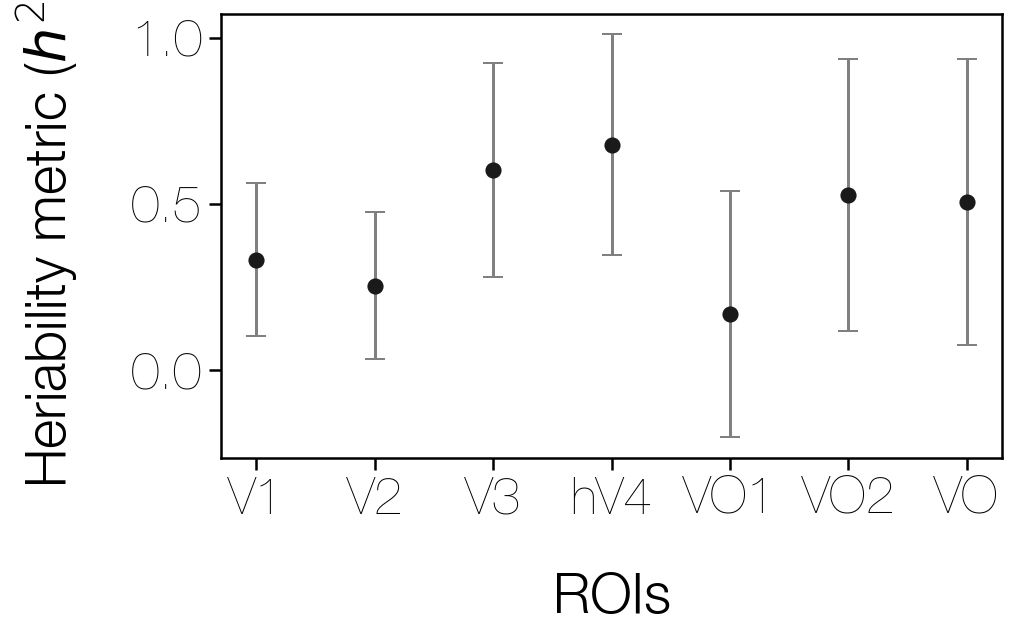

In [194]:
# 95% ci (it is important to see if the errorbar includes 0 )
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
hue_offsets = np.linspace(-0.2, 0.2, len(hues))  # Adjust based on the number of hues and desired spacing

for i, category in enumerate(categories):
    # Filter data for this category and hue
    subset = final_icc_df[final_icc_df['ROI'] == category]
    x_positions = category_positions[i]
    # Add error bars (assuming 'CI95%' column contains [lower, upper] bounds)
    for _, row in subset.iterrows():
        ax.errorbar(x_positions, 
                    row['h2'], c='gray', linewidth=1.5,
                    yerr=row[f'std_h2'], 
                    fmt='none', capsize=5, zorder=1)
    # Plot points
    ax.scatter([x_positions] * len(subset), 
               subset['h2'], s=50,  
               color = 'k',
               zorder=2)

    ax.set_xticks(category_positions)
    ax.set_xticklabels(categories)
    ax.set_xlabel('ROIs')
    ax.set_ylabel(r'Heriability metric ($h^{2}$)')

plt.subplots_adjust()
plt.savefig(os.path.join(fig_dir, 'icc_h2.svg'))
plt.show()